# Random forest-based feature importance

### Bank Marketing Data Set 

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

Each record included the output target, the contact outcome ({“failure”, “success”}), and candidate input features. These include telemarketing attributes (e.g., call direction), product details (e.g., interest rate
offered) and client information (e.g., age). 

The data were collected from 2008 to 2013, thus including the effects of the global financial crisis that peaked in 2008.

In [8]:
import pandas as pd
bank = pd.read_csv('datasets/bank-full.csv', delimiter=';' )
bank.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


Our questions:
- which features are important?
- if we throw away some unimportant features, can we improve the performance?


### Categorical features: let's check the # of unique values

Very important step, if there is a column with 1000 unique values, **don't** do one-hot encoding.

In [9]:
cat_feats = ['job','marital', 'education','default', 'housing', 'loan', 'contact', 'poutcome', 'month']
#loan was binary, then cast to onehotencoder, and drop first. 
for cat_feature in cat_feats:
    print(bank[cat_feature].unique())

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
['married' 'single' 'divorced']
['tertiary' 'secondary' 'unknown' 'primary']
['no' 'yes']
['yes' 'no']
['no' 'yes']
['unknown' 'cellular' 'telephone']
['unknown' 'failure' 'other' 'success']
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']


In [10]:
# we will do something different to 'month', for the remaining features, we will apply one-hot encoding
cat_feats.remove('month')
cat_feats

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome']

In [11]:
bank = pd.get_dummies(bank,columns=cat_feats,drop_first=True) #one hot encoding.
bank.head(3)

,age,balance,day,month,duration,campaign,pdays,previous,y,job_blue-collar,...,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,may,261,1,-1,0,no,0,...,1,0,0,1,0,0,1,0,0,1
1,44,29,5,may,151,1,-1,0,no,0,...,0,0,0,1,0,0,1,0,0,1
2,33,2,5,may,76,1,-1,0,no,0,...,0,0,0,1,1,0,1,0,0,1


In [13]:
mymap1 = {'jan':1,'feb':2,'mar':3, 'apr':4, 'may':5,'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
#ordinal so put into a dictionary. Could argue this isn't ordinal and jut do one hot encoder (month just a feature)

bank = bank.applymap(lambda s: mymap1.get(s) if s in mymap1 else s)
bank.head(3)

,age,balance,day,month,duration,campaign,pdays,previous,y,job_blue-collar,...,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,5,261,1,-1,0,no,0,...,1,0,0,1,0,0,1,0,0,1
1,44,29,5,5,151,1,-1,0,no,0,...,0,0,0,1,0,0,1,0,0,1
2,33,2,5,5,76,1,-1,0,no,0,...,0,0,0,1,1,0,1,0,0,1


In [16]:
from sklearn.model_selection import train_test_split
X = bank.drop('y',axis=1)
y = bank['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [15]:
# Import the random forest model and accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score

# This line instantiates the model. 
rf = RandomForestClassifier() 

# Fit the model on your training data.
rf.fit(X_train, y_train) 
y_predict = rf.predict(X_test)

# And score it on your testing data.

accuracy_score(y_test, y_predict)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8991447950457092

Why didn't I do a standard scaler? Not necessary in random forest- lots of decision tree.   
In decision tree, not measuring distances between two instances so doesn't matter if you scale or not

## Feature importance
These methods are most often used for prediction, but looking at the feature importances can give you a sense of which of your variables have the most effect in these models. 
You can:
- use that information to engineer new features, 
- drop out features that look like noise, 
- inform you as you continue building models.

Decision trees, and the ensemble methods that are built on them, work by splitting the data into subsets which most heavily belong to one class. The tree will continue to build different subsets until it understands and represents the relationship of the variables with the target. All kinds of tree methods calculate their splits by mathematically determining which split will most effectively help distinguish the classes. Because that is their method, the sklearn instances of these models have a .**feature_importances_** attribute, which returns an array of each feature’s importance in determining the splits.

In decision tree, doing a greedy algorithm: find split that maximizes split.   
If we do a lot of splits on one feature, then that feature might be a good feature.   
In random forests, if you look what features most trees are splitting on will give us a goood idea.

Feature importance: **the higher, the more important the feature**

In [8]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
#put series into dataframe
#index with column names
#then want to sort from high to low

feature_importances 

,importance
duration,0.269007
balance,0.106956
age,0.099791
day,0.094339
month,0.074218
pdays,0.055356
poutcome_success,0.050601
campaign,0.039420
housing_yes,0.027109
previous,0.021014


job_management: is the one hot encoded job. SHows that the jobs are not that important. 

### ...so how does the importances calculated? - *mean decrease in impurity*

The **mean decrease in impurity** importance of a feature is computed by measuring how effective the feature is at reducing uncertainty (classifiers) when creating decision trees within RFs. The problem is that this mechanism, while fast, does not always give an accurate picture of importance. Breiman and Cutler, the inventors of RFs, indicate that this method of “adding up the gini decreases for each individual variable over all trees in the forest gives a **fast** variable importance that is often very **consistent** with the permutation importance measure.” (Emphasis ours and we'll get to permutation importance shortly.)

## Rule of thumb about feature importance...

Ask **domain expert** for important features, this is the best feature engineering a data scientist can do.

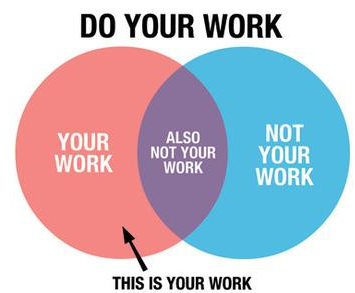

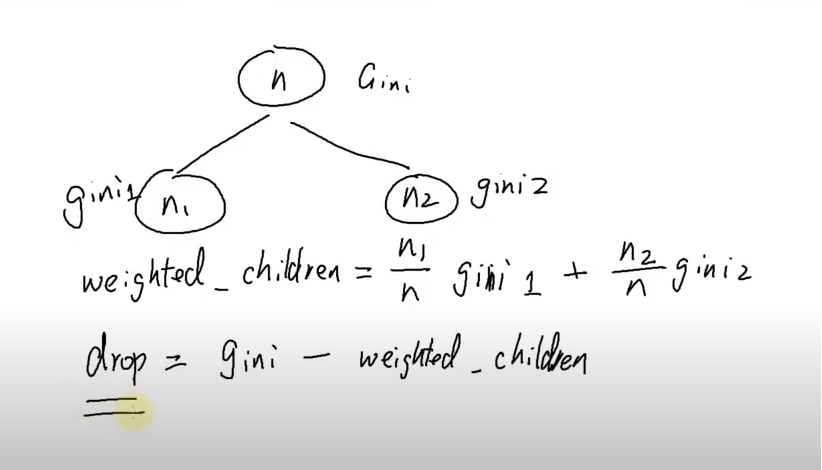


So if this feature has a lot of splits, and the drop is a lot- then this must be a good feature.  

Is this a good way to get feature importance? This is the FIRST way, but there are more robust ways grounded by theoretical proofs.   

However, some people say decision tree is a good one. 


Is feature importance job for data scientist: not always. Ask domain expert- they should provide enough domain knowledge for project, but ask domain expert for feature importance. 

## Exercise:
We used feature mapping to map *month* to integers. How about we also treat this column as other categorical features? If we add all the importance of 11 different values together, what will we get?

Start from the original dataset again.


In [31]:
# load data and apply one-hot encoder
import pandas as pd
bank = pd.read_csv('datasets/bank-full.csv', delimiter=';' )

cat_feats = ['job','marital', 'education','default', 'housing', 'loan', 'contact', 'poutcome', 'month'] #add month to make part of one hot encoding


bank = pd.get_dummies(bank,columns=cat_feats,drop_first=True) #one hot encoding.
bank.head(3)

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,58,2143,5,261,1,-1,0,no,0,0,...,0,0,0,0,0,0,1,0,0,0
1,44,29,5,151,1,-1,0,no,0,0,...,0,0,0,0,0,0,1,0,0,0
2,33,2,5,76,1,-1,0,no,0,1,...,0,0,0,0,0,0,1,0,0,0


In [29]:
# train-test split again
from sklearn.model_selection import train_test_split

X = bank.drop('y',axis=1)
y = bank['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [32]:
# Import the random forest model and accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score

# This line instantiates the model. 
rf = RandomForestClassifier() 

# Fit the model on your training data.
rf.fit(X_train, y_train) 


# get the feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)


feature_importances 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,importance
duration,0.269915
balance,0.098002
age,0.094489
day,0.085692
poutcome_success,0.058492
campaign,0.041104
pdays,0.039479
housing_yes,0.022350
previous,0.021204
contact_unknown,0.014023


In [34]:
# Get the sum of all the features looks like "month_*"
month_importance_sum = 0

for i in feature_importances.index:
    if i.startswith('month_'):
        month_importance_sum += feature_importances['importance'][i]
month_importance_sum

0.09911048458909343

### Discuss:
Which month is the most important feature?  
    March (highest feature importance)

Does this mean there are more successful sales in that month?
    No- it could be there are a lot of sales in March, or the opposite- maybe March sales are the least successful. 



## Exercise
Performance of the random forest model with top *n* features.

We can see there are a total of 42 features, try to use different number of important features to build random forest models and track the changes of accuracy scores. You can devide the step size of n, but try not to copy-paste your own code.

In [38]:
# Let's check the number of features
feature_importances.index.size

42

In [39]:
# Let's try to select the most important two features
feature_importances.index[:2]

Index(['duration', 'balance'], dtype='object')

In [47]:
# Cast to a list
list(feature_importances.index[:2])

['duration', 'balance']

In [49]:
# Only select those two features from the training set
Xs=X_train[list(feature_importances.index[:2])] #train set only has to two most important features

In [51]:
# create random forest model. 

rf = RandomForestClassifier()

# Fit the model on your training data with only 2 features selected
rf.fit(Xs,y_train)

# then mapre predictions with X_test with the same 2 features
predictions=rf.predict(X_test[list(feature_importances.index[:2])])

# And score it on your testing data.
accuracy_score(y_test,predictions)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8670746092598054

In [54]:
# use the range below to get the accuracies for each top n features 
range_of_features = list(range(2,42,5))

# Try to define a function which runs a random forest with top n 


# feature and return the accuracy

def accuracy_top_n_features(n):
        rf=RandomForestClassifier()
        rf.fit(X_train[list(feature_importances.index[:n])], y_train)
        y_predict= rf.predict(X_test[list(feature_importances.index[:n])])
        return accuracy_score(y_test,y_predict)

accuracy_scores = []
for n in range_of_features:
        current_accuracy = accuracy_top_n_features(n)
        accuracy_scores.append(current_accuracy)

accuracy_scores  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

[0.8713506340312592,
 0.8953848422294308,
 0.9006930109112357,
 0.9024624004718372,
 0.9014302565614863,
 0.9051164848127397,
 0.9006192863462106,
 0.9031259215570628]

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

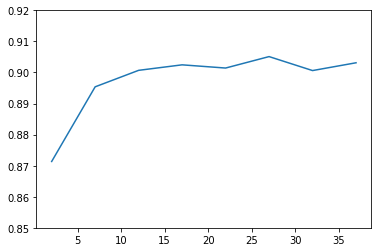

In [56]:
import matplotlib.pyplot as plt
plt.plot(range_of_features,accuracy_scores)
plt.ylim((.85,.92))
plt


## To sum up:
- Feature importance can be generated in on the fly of buiding a random forest model
    - Based on the gini/entropy decreases
- But we have to process the categorical features first
- You don't have to use all the features to build a model
    - Domain experts should be your consultants on feature importance

Top 7 seems good. 